In [1]:
import argparse
import pickle
import numpy as np
import datetime as dt
import pandas as pd
from sklearn.model_selection import GroupShuffleSplit
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import average_precision_score

In [2]:
fmat_file = '../ppi_ml/data/featmats/featmat_labeled_traintest.pkl'
featsel_file = '../ppi_ml/results/feature_selection/archive/featsel_xtrees_allres.csv'
num_splits = 5
n_feats2sel = 130

In [3]:
def fmt_data(fmat, select_feats, subset, label_cols, data_cols, keep_groups=True):
    
    # get desired subset
    fmat_fmt = fmat[fmat['label'].isin(subset)]
    fmat.sort_values('label', inplace=True, ascending=False)
    fmat.reset_index(inplace=True, drop=True)
    
    # format data for sklearn input
    X = fmat_fmt[data_cols].to_numpy()
    y = fmat_fmt[label_cols[1]].to_numpy()
    ids = fmat_fmt[label_cols[0]]
    
    if keep_groups:
        groups = fmat_fmt[label_cols[2]].to_numpy()
        fmat.sort_values(label_cols[2], inplace=True, ascending=True)
        fmat.reset_index(inplace=True, drop=True)
        return(X, y, ids, groups)
    else:
        return(X, y, ids)

In [4]:
def get_scores(model, array, labels, ids):
    
    # predict probability scores
    scores = model.predict_proba(array)
    probabilities = np.split(scores, 2, axis=1)
    neg_prob = probabilities[0]
    pos_prob = probabilities[1]
    ap = average_precision_score(y_test, pos_prob)
    
    # format into df
    df = pd.DataFrame()
    df['ID'] = ids
    df['label'] = labels
    df['ppi_score'] = pos_prob
    df['avg_precision'] = ap
    df.sort_values('ppi_score', inplace=True, ascending=False)
    df.reset_index(inplace=True, drop=True)
    
    return(df)

In [5]:
def calc_pr(df):

    tp_count = 0
    fp_count = 0
    p_list = []
    r_list = []
    f_list = []
    all_pos = len(df[df['label'] == 1])

    for i in range(len(df)):

        if df['label'][i] == 1:
            tp_count += 1
        else:
            fp_count += 1

        tps = tp_count
        fps = fp_count
        fns = all_pos - tps

        precision = tps/(tps+fps)
        recall = tps/(tps+fns)
        fdr = 1 - precision

        p_list.append(float(precision))
        r_list.append(float(recall))
        f_list.append(float(fdr))

    df['precision'] = p_list
    df['recall'] = r_list
    df['fdr'] = f_list
    
    return(df)

In [6]:
print(f'Reading in data ...')
with open(fmat_file, 'rb') as handle:
    fmat = pickle.load(handle)
fsel = pd.read_csv(featsel_file)
select_feats = fsel['feature'].head(n_feats2sel).tolist()
print(f'# feats selected: {len(select_feats)}')

Reading in data ...
# feats selected: 130


In [7]:
label_cols = ['ID', 'label', 'super_group']
data_cols = [c for c in fmat.columns.values.tolist() if c not in label_cols and c in select_feats]

# Run CV

In [8]:
gs = GroupKFold(n_splits=num_splits)
clf = ExtraTreesClassifier(bootstrap=True, criterion="gini", 
                           max_features=0.7, min_samples_leaf=3, 
                           min_samples_split=14, n_estimators=100,
                           n_jobs=8, random_state=13)
X, y, ids, groups = fmt_data(fmat, select_feats, [1,-1], label_cols, data_cols, keep_groups=True)

In [9]:
res_lst = []
for i, (train_idx, test_idx) in enumerate(gs.split(X, y, groups)):

        X_train = X[train_idx]
        y_train = y[train_idx]
        X_test = X[test_idx]
        y_test = y[test_idx]

        print(f'Running CV for split #{i+1}...')
        print(f"\tTrain: index={train_idx}, group={groups[train_idx]}")
        print(f"\tTest:  index={test_idx}, group={groups[test_idx]}")
        print(f"\ty--> # train PPIs = {len(X[train_idx])}")
        print(f"\t--> # test PPIs = {len(X[test_idx])}")
        
        clf.fit(X_train, y_train)
        test_ids = ids[test_idx]
        test_scores = get_scores(clf, X_test, y_test, test_ids)
        pr_data = calc_pr(test_scores)
        
        pr_data['fold'] = int(i+1)
        res_lst.append(pr_data)

Running CV for split #1...
	Train: index=[    0     3     6 ... 26509 26510 26515], group=[511  47  17 ...  10  55 494]
	Test:  index=[    1     2     4 ... 26512 26513 26514], group=[1 1 1 ... 1 1 1]
	y--> # train PPIs = 10831
	--> # test PPIs = 15685
Running CV for split #2...
	Train: index=[    0     1     2 ... 26513 26514 26515], group=[511   1   1 ...   1   1 494]
	Test:  index=[    8    10    31 ... 26498 26502 26510], group=[  56   55   45 ... 1132   56   55]
	y--> # train PPIs = 23808
	--> # test PPIs = 2708
Running CV for split #3...
	Train: index=[    0     1     2 ... 26513 26514 26515], group=[511   1   1 ...   1   1 494]
	Test:  index=[   29    63    66 ... 26499 26506 26509], group=[793 130  10 ...  10  63  10]
	y--> # train PPIs = 23808
	--> # test PPIs = 2708
Running CV for split #4...
	Train: index=[    1     2     4 ... 26512 26513 26514], group=[1 1 1 ... 1 1 1]
	Test:  index=[    0     3    18 ... 26448 26486 26515], group=[511  47  19 ...  47  37 494]
	y--> # trai

In [10]:
all_res = pd.concat(res_lst)
all_res

,ID,label,ppi_score,avg_precision,precision,recall,fdr,fold
0,KOG0359 KOG0364,1,1.000000,0.709686,1.000000,0.000262,0.000000,1
1,KOG0361 KOG0362,1,0.998750,0.709686,1.000000,0.000524,0.000000,1
2,KOG1942 KOG2680,1,0.998750,0.709686,1.000000,0.000786,0.000000,1
3,KOG0358 KOG0361,1,0.998750,0.709686,1.000000,0.001048,0.000000,1
4,KOG0364 KOG0361,1,0.997321,0.709686,1.000000,0.001311,0.000000,1
...,...,...,...,...,...,...,...,...
2702,KOG1034 KOG1666,-1,0.001984,0.806308,0.200888,1.000000,0.799112,5
2703,KOG1331 KOG4390,-1,0.001667,0.806308,0.200814,1.000000,0.799186,5
2704,KOG3047 KOG3284,-1,0.001579,0.806308,0.200739,1.000000,0.799261,5
2705,KOG2760 KOG1920,-1,0.001111,0.806308,0.200665,1.000000,0.799335,5


In [11]:
all_res.to_csv('../ppi_ml/results/ml_eval/groupkfoldcv_k-5_s-13.csv')

# Plot CV

ugggghhhh this is so dumb. as always I'm just going to write out results to plot in R w/ ggplot.

In [12]:
from matplotlib.patches import Patch
import matplotlib.pyplot as plt
import seaborn as sns

In [13]:
# colors
cmap_data = plt.cm.Paired
cmap_cv = plt.cm.coolwarm

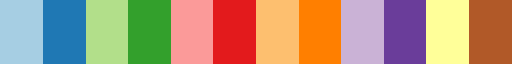

In [14]:
cmap_data

In [15]:
# turn to string
all_res['fold'] = all_res.fold.astype(str)

labels = []
avg_pre = all_res[['fold','avg_precision']].drop_duplicates()
avg_pre.reset_index(inplace=True, drop=True)

for i in range(len(avg_pre)):
    fold = avg_pre['fold'][i]
    ap = avg_pre['avg_precision'][i]
    l = f'KFold-{fold} (AP={round(ap, 2)})'
    labels.append(l)

labels

['KFold-1 (AP=0.71)',
 'KFold-2 (AP=0.86)',
 'KFold-3 (AP=0.92)',
 'KFold-4 (AP=0.88)',
 'KFold-5 (AP=0.81)']

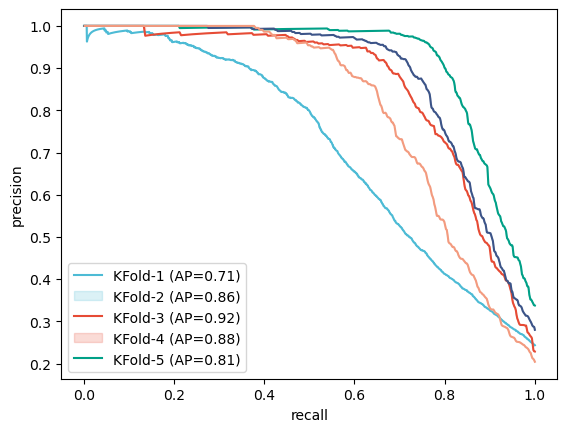

In [16]:
# plot w/ custom palette, legend:
sns.lineplot(x='recall', 
             y='precision',
             hue='fold', 
             palette=["#4DBBD5", "#E64B35", "#00A087", "#3C5488", "#F39B7F"],
             data=all_res,
             legend=False)
plt.legend(labels=labels, loc='lower left', title=None)
plt.savefig(f'../ppi_ml/results/ml_eval/groupkfoldcv_k-5_s-13.png', dpi=300, transparent=True)
plt.show()